In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex = False)
import pandas as pd
import seaborn as sns
from scipy.stats import semicircular
import os

In [2]:
import matplotlib; mpl =matplotlib
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (12.0,9.0) # default = (6.0, 4.0)
mpl.rcParams['font.size']      = 24        # default = 10

mpl.rcParams['axes.linewidth']    = 0.75 # default = 1.0
mpl.rcParams['lines.linewidth']   = 1.5 # default = 1.0
mpl.rcParams['patch.linewidth']   = 1.0 # default = 1.0
mpl.rcParams['grid.linewidth']    = 0.5 # default = 0.5
mpl.rcParams['xtick.major.width'] = 1.0 # default = 0.5
mpl.rcParams['xtick.minor.width'] = 0.0 # default = 0.5
mpl.rcParams['ytick.major.width'] = 1.0 # default = 0.5
mpl.rcParams['ytick.minor.width'] = 0.0 # default = 0.5

colors = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec'];

def make_nice_axis(ax):
    """ Function to beautify axis"""

    ax.spines['top'].set_visible(False) # hide top axs
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 30))
    ax.spines['left'].set_position(('outward', 30))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(pad=10)
    ax.yaxis.set_tick_params(pad=10)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 20
    
# def plotly_beautify(plotly_fig):
#     plotly_fig['layout']['xaxis1']['showline'] = True
#     plotly_fig['layout']['yaxis1']['showline'] = True
#     plotly_fig['layout']['xaxis1']['showgrid'] = True
#     plotly_fig['layout']['yaxis1']['showgrid'] = True
#     plotly_fig['layout']['showlegend'] = True

# Running relpicates to determine Jacobian for random fluids

In [32]:
Ntrials = 100;
minJ = [];
minJeff = [];
J_all = [];
J_eff_all = [];
r_all = [];
mean_centered_X = [];
std_centered_X = [];
# Number of components
N = 50;

# Distribution of interactions (mean,variance)
mean = 0.0;
alpha = 1.5;
std =alpha*(N**0.5)

beta = 1.0*N/(N+1);
# beta = 0.2;
phi = beta*np.ones((N,1))/N;
# Define initial polydispersity
r_mu = 1;
r_sigma = 0.0;

for k in np.arange(Ntrials):

    chi = std*np.random.randn(N,N) + mean + 1.0/(1-beta);
    np.fill_diagonal(chi,  0);
#     chi[-1,:] = 0.0;

    g = np.zeros((N,N))


    r = r_sigma*np.random.randn(N,1) +r_mu ;
#     r = r_sigma*np.random.lognormal(r_mu,r_sigma,size=(N,1)) ;

#     r = np.random.geometric(p=r_sigma, size=(N,1))
#     print(np.mean(r))
    r[r<1] = 1;
    r_all.append(r)
    # Define Jacobian matrix
    D = np.zeros((N,N));
    np.fill_diagonal(D, 1/(phi*r) + 1.0/(1-beta))

    # Fill in chi and mobility matrices
    np.fill_diagonal(g, phi*(1-phi))

    for i in np.arange(len(chi)-1):
        for j in np.arange(i+1,len(chi)):
            chi[i,j] = chi[j,i]
            g[i,j] = -phi[i]*phi[j]
            g[j,i] = g[i,j]
    
    # Define reaction matrix
    R = np.zeros((N,N))
#     np.fill_diagonal(R,-1*k_diag)
    
    wg, vg = np.linalg.eig(g)

    J = D + chi ;
    Chi_eff = (chi+D - np.mean(np.diag(D))*(np.identity(N)))
    std_centered_X.append(np.std(Chi_eff))
    wJ, vJ = np.linalg.eig(J)
    mean_centered_X.append(np.linalg.eigvals(chi+D - np.mean(np.diag(D))*(np.identity(N))))
    wchi = np.linalg.eigvals(chi)
    Jeff = np.matmul(g,J);
    wJeff,vJeff = np.linalg.eig(Jeff)
    minJ.append(np.min(wJ))
    minJeff.append(np.min(wJeff))
    J_all.append(wJ)
    J_eff_all.append(wJeff)

In [35]:
print(chi)

[[ 0.         35.85852347 66.45492671 ... 60.48260574 54.43745659
  60.1089528 ]
 [35.85852347  0.         55.84083051 ... 61.4878071  50.12865189
  35.4070855 ]
 [66.45492671 55.84083051  0.         ... 58.10041806 59.09233363
  51.18491348]
 ...
 [60.48260574 61.4878071  58.10041806 ...  0.         44.79773364
  38.00365888]
 [54.43745659 50.12865189 59.09233363 ... 44.79773364  0.
  61.55517518]
 [60.1089528  35.4070855  51.18491348 ... 38.00365888 61.55517518
   0.        ]]


## Normalizing eigen-values by the entropic cost and also by the Wigner factor (2 $ \sigma $ $ \sqrt N $)

In [36]:
entropic_average =np.mean(1/np.array(r_all))
print(entropic_average*N/beta)
normalized_eigen_values = (np.array(J_all).flatten() - 1*entropic_average*N/beta)/(2*std*N**0.5)
x = np.linspace(semicircular.ppf(0.01),

                semicircular.ppf(0.99), 100)

outside_eigen_value = (N*(1/(1-beta) + mean))/(2*std*N**0.5)

outfolder = '../Output/Theory_figures/20210328/'
out_file_vars = ["N","mean","std","beta","r_mu","r_sigma"];
outfile = ""
for var in out_file_vars:
    outfile += var + "_" + str(eval(var)) + "_"
print(outfile)


51.0
N_50_mean_0.0_std_10.606601717798213_beta_0.9803921568627451_r_mu_1_r_sigma_0.0_


### Plotting distribution of all eigen-values

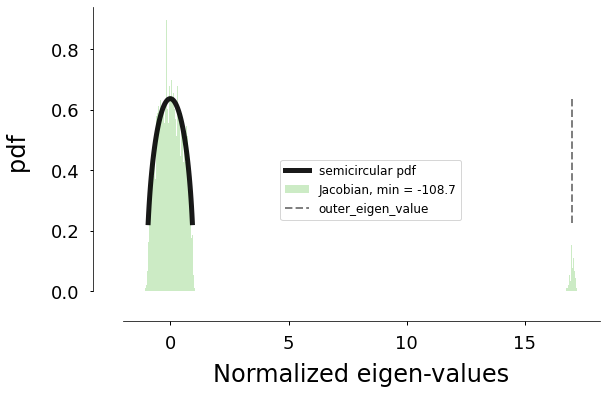

In [37]:
fig,axes = plt.subplots(1,1,figsize=(9,6))
make_nice_axis(axes)
axes.hist(normalized_eigen_values,density=True,bins=1000,label='Jacobian, min = ' + str(round(min(np.array(J_all).flatten()),2)),color=colors[2])
axes.plot(x, semicircular.pdf(x),color='black', lw=5, alpha=0.9, label='semicircular pdf')
axes.vlines(outside_eigen_value,min(semicircular.pdf(x)),max(semicircular.pdf(x)),lw=2,color='grey',linestyles='--',label="outer_eigen_value")

axes.set_xlabel('Normalized eigen-values')
axes.set_ylabel('pdf ')
axes.legend(bbox_to_anchor=(0.75, 0.6),
           bbox_transform=plt.gcf().transFigure,fontsize=12)
plt.tight_layout()


file_save = False;
if file_save:
    os.makedirs(outfolder+outfile,exist_ok=True)
    fig.savefig(fname= outfolder+outfile+"/all_eigen.png",format='pdf',dpi=300)

    fig.savefig(fname= outfolder+outfile+"/all_eigen.pdf",format='pdf',dpi=300)
plt.show()

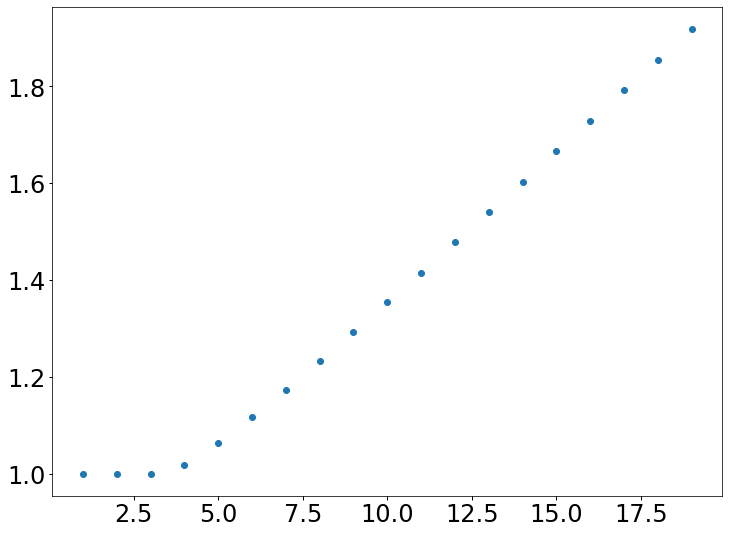

In [54]:
Nm = 20;
alpha =0.65
x = []
y = [];
for N in range(1,Nm):
    ratio = -(N+1)/(2*alpha*N)
    x.append(N)
    y.append(N*semicircular.cdf(ratio)+1)
    
plt.scatter(x,y)
plt.show()

-52.599663668865105


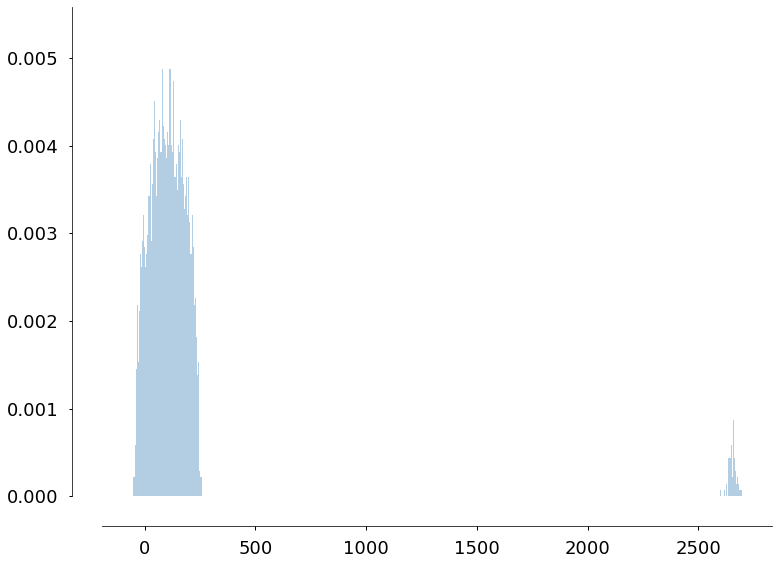

In [31]:
fig,axes = plt.subplots(1,1)
make_nice_axis(axes)
axes.hist(np.array(J_all).flatten(),density=True,bins=1000,label='Jacobian, min = ' + str(round(min(np.array(J_all).flatten()),2)),color=colors[1])
print(np.array(J_all).flatten().min())
plt.show()

### Plotting distribution of eigen-values and min eigen-vector for 1 realization

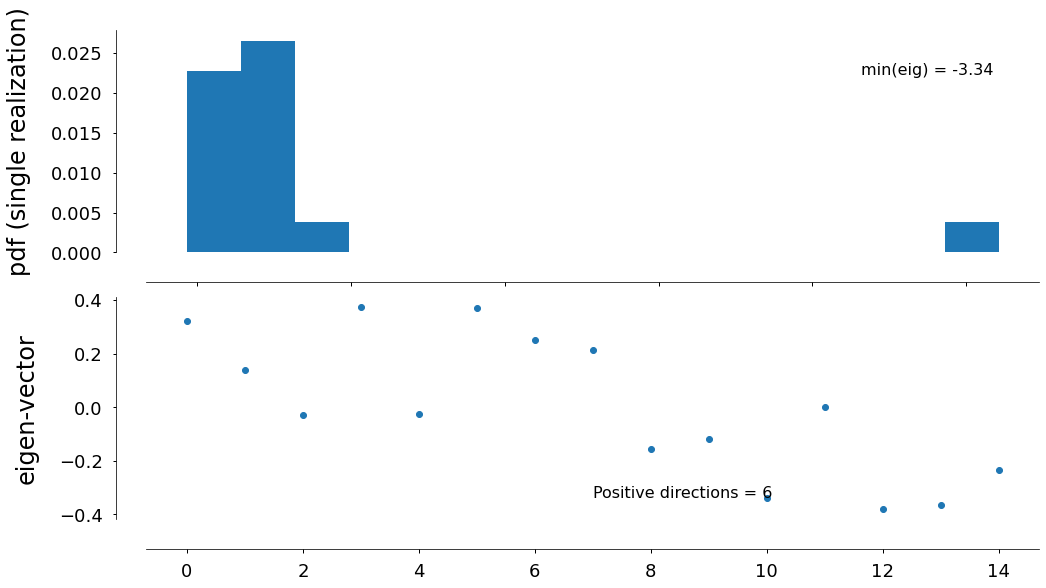

In [26]:
w, v = np.linalg.eig(J)

fig,axes = plt.subplots(2,1,figsize=(16,9))
for ax in axes:
    make_nice_axis(ax)
axes[0].hist(w,density=True,bins=15)
axes[0].text(0.8,0.8,"min(eig) = " + str(round(np.min(w),2)),transform=axes[0].transAxes,fontsize=16)
axes[0].set_ylabel('pdf (single realization)')

axes[1].scatter(range(N),v[:,np.where(w==np.min(w))[0][0]])
axes[1].text(0.5,0.1,"Positive directions = " + str(sum(v[:,np.where(w==np.min(w))[0][0]]>0)),transform=axes[1].transAxes,fontsize=16)
axes[1].set_ylabel('eigen-vector')

# axes[2].scatter(v[:,np.where(w==np.min(w))[0][0]]*np.sqrt(N),np.log(r))

file_save = False;
if file_save:
    os.makedirs(outfolder+outfile,exist_ok=True)

    fig.savefig(fname= outfolder+outfile+"/one_realization.pdf",format='pdf',dpi=300)

plt.show()

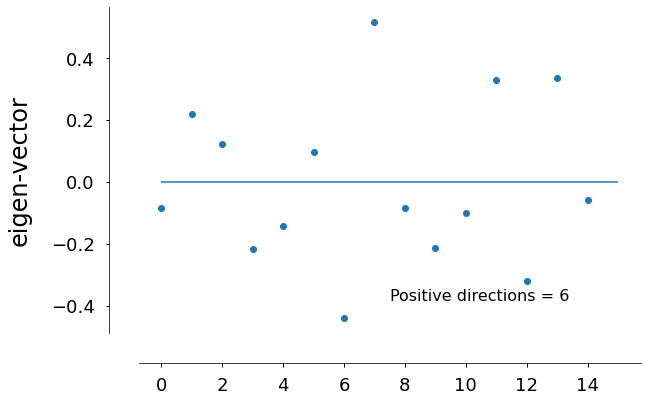

In [42]:
w, v = np.linalg.eig(J)

fig,axes = plt.subplots(1,1,figsize=(9,6))
make_nice_axis(axes)
axes.scatter(range(N),v[:,np.where(w==np.min(w))[0][0]])
axes.text(0.5,0.1,"Positive directions = " + str(sum(v[:,np.where(w==np.min(w))[0][0]]>0)),transform=axes.transAxes,fontsize=16)
axes.hlines(0,0,N)
axes.set_ylabel('eigen-vector')

# axes[2].scatter(v[:,np.where(w==np.min(w))[0][0]]*np.sqrt(N),np.log(r))

file_save = True;
if file_save:
    os.makedirs(outfolder+outfile,exist_ok=True)

    fig.savefig(fname= outfolder+outfile+"/one_realization.pdf",format='pdf',dpi=300)

plt.show()

### Plotting distribution of all eigen-values and that of the minimum eigen-value

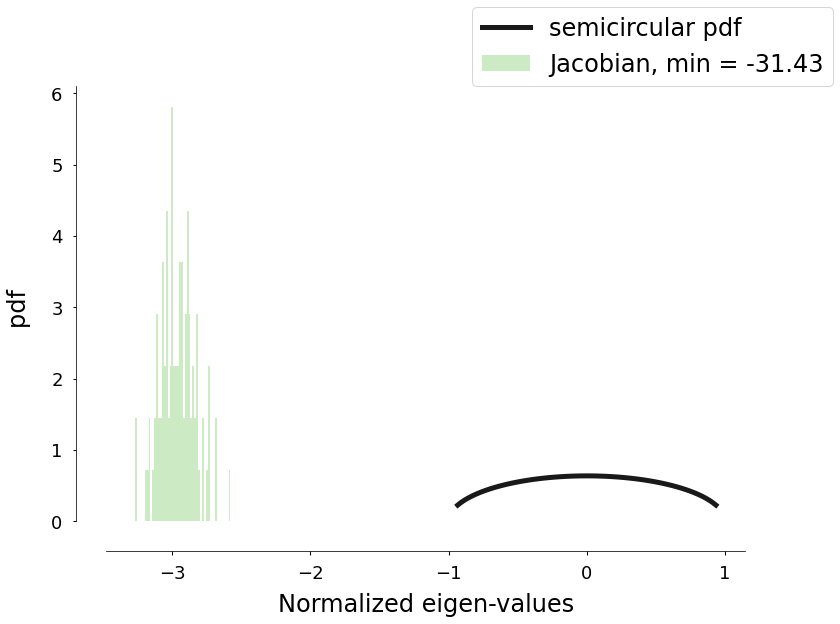

In [132]:
a = [];
for i in np.arange(len(J_all)):
    a.append(min(J_all[i]))
    
normalized_min = (np.array(a).flatten() - entropic_average*N/beta)/(2*std*N**0.5)

fig,axes = plt.subplots(1,1)
make_nice_axis(axes)
# axes.hist(normalized_eigen_values,density=True,bins=1000,label='Jacobian, min = ' + str(round(min(np.array(J_all).flatten()),2)),color=colors[1])
axes.hist(normalized_min,density=True,bins=50,label='Jacobian, min = ' + str(round(min(np.array(J_all).flatten()),2)),color=colors[2])
# axes.vlines(-1,min(semicircular.pdf(x)),max(semicircular.pdf(x)),lw=2,color='grey',linestyles='--',label="edge_wigner")

axes.plot(x, semicircular.pdf(x),color='black', lw=5, alpha=0.9, label='semicircular pdf')
# axes.vlines(outside_eigen_value,min(semicircular.pdf(x)),max(semicircular.pdf(x)),lw=2,color='grey',linestyles='--',label="outer_eigen_value")

axes.set_xlabel('Normalized eigen-values')
axes.set_ylabel('pdf ')
axes.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.tight_layout()


file_save = True;
if file_save:
    os.makedirs(outfolder+outfile,exist_ok=True)

    fig.savefig(fname= outfolder+outfile+"/all_eigen_min_eigen.pdf",format='pdf',dpi=300)
plt.show()

### Plotting distribution of polydispersity

0.251034945870282


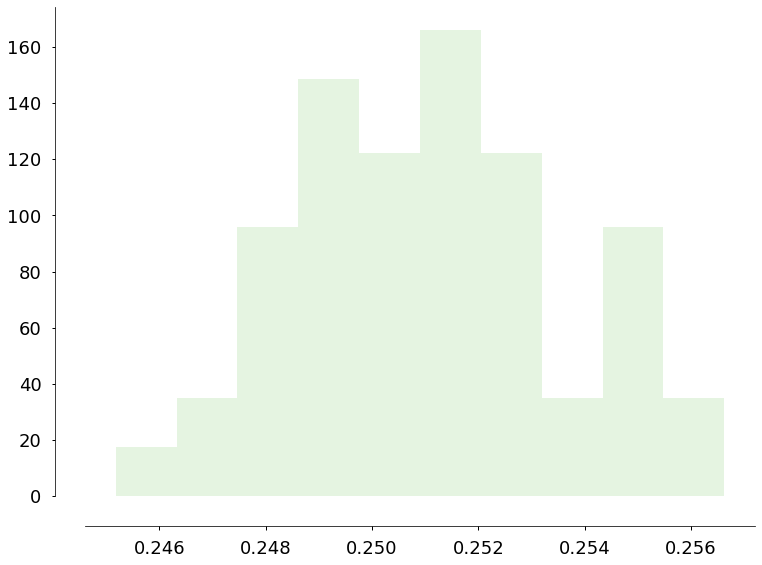

In [124]:
a = [];
for i in np.arange(len(r_all)):
    a.append(N*np.mean(1/r_all[i]))
print(np.mean(a))
fig,axes = plt.subplots(1,1)
make_nice_axis(axes)
axes.hist(np.array(a).flatten(),density=True,color=colors[2],alpha=0.5)
plt.show()

99.83948724723086
2.571968714162552e-05
0.9765244492586962


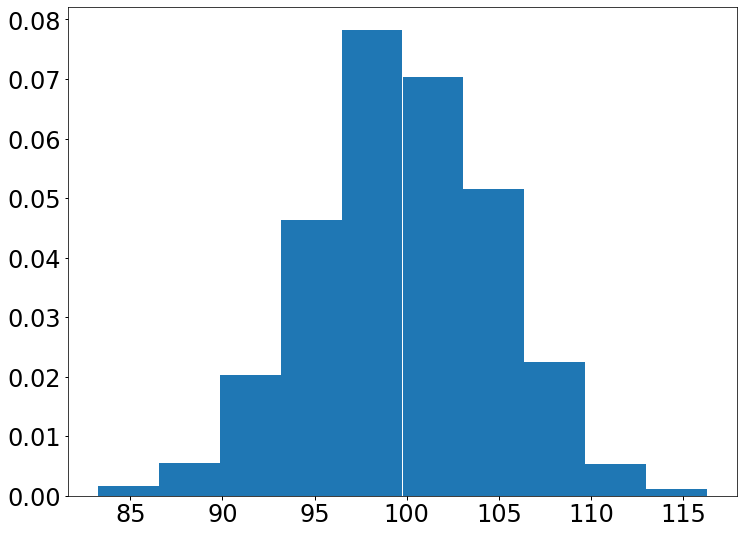

In [125]:
fig,axes = plt.subplots(1,1)
axes.hist(np.array(r_all).flatten(),density=True)
print(np.mean(r_all))
print(100*np.var(1/np.array(r_all).flatten()))
print(np.sqrt((1-r_sigma)/(r_sigma**2) + (N-1)*std**2)/np.sqrt(N))
plt.show()

In [ ]:
minJ = np.array(minJ);
minJ[np.abs(minJ)<1e-10]=0.0

minJeff = np.array(minJeff);
minJeff[np.abs(minJeff)<1e-10]=0.0

p = np.array(minJ)*np.array(minJeff)
print(np.sum(p<0),np.sum(np.array(minJ)>0))

In [ ]:
Chi_eff = (chi+D - np.mean(np.diag(D))*(np.identity(N)))
print(np.std(np.diag(D - np.mean(np.diag(D))*(np.identity(N)))))
print(np.std(chi))
print(np.std(J))

In [ ]:
fig,axes = plt.subplots(1,1)
axes.hist(np.array(mean_centered_X).flatten(),density=True)
print(np.mean(1/(phi*r_all)))
print(2*std*N**0.5)
print(min(np.array(mean_centered_X).flatten()),max(np.array(mean_centered_X).flatten()))
print(min(np.array(mean_centered_X).flatten())/(2*N**0.5))
plt.show()

In [ ]:
fig,axes = plt.subplots(1,1)
axes.hist(np.array(J_eff_all).flatten(),density=True)
print(np.mean(1/(phi*r)))
print(2*std*N**0.5)
print(min(np.array(J_eff_all).flatten()),np.mean(1/(phi*r))-2*std*N**0.5)
plt.show()

In [ ]:
r

In [ ]:
fig,axes = plt.subplots(2,1)
axes[0].hist(w)
axes[0].text(0.8,0.8,"min(eig) = " + str(round(np.min(w),2)),transform=axes[0].transAxes)

axes[1].plot(v[:,np.where(w==np.min(w))[0][0]])
axes[1].text(0.5,0.1,"Positive directions = " + str(sum(v[:,np.where(w==np.min(w))[0][0]]>0)),transform=axes[1].transAxes)
plt.show()

In [ ]:
q = np.arange(0.01,1,step=0.01);
Mobility = 1.0
w_tot = [];
for k in q:
    J_eff = -J*Mobility*k*k + R
    w_tot.append(max(np.linalg.eigvals(J_eff)))

fig,axes = plt.subplots(1,1)
axes.semilogx(q,w_tot)
plt.show()

## Import proteome data

In [4]:
file_to_read = '../data/proteome.xlsx'
pdata = pd.read_excel(file_to_read,sheet_name='HeLa proteome')

In [5]:
pdata.columns
pdata['seq_log_norm'] = np.log(pdata["Sequence.length"])
pdata['c_log_norm'] = np.log(pdata["Concentration [nM]"])


In [6]:
phi = (pdata["Sequence.length"]*pdata["Concentration [nM]"]*1e-9*140*1e-27*6.023*1e23)
pdata["phi"] = phi
pdata["phi_log_norm"] = np.log(phi)


In [16]:
namep ='CTR9';
conc_p = pdata.iloc[np.where(pdata['Gene.name']==namep)[0],:]
conc_p

,Protein.IDs,Majority.protein.IDs,Gene.name,Entry.name,Protein.name,Sequence.length,Average.molecular.weight,Monoisotopic.molecular.weight,Number.of.theoretical.peptides,LFQ.intensity.HeLa_1,...,Peptides,Razor+unique.peptides,Sequence.coverage [%],Unique+razor.sequence.coverage [%],Copy.number,Concentration [nM],seq_log_norm,c_log_norm,phi,phi_log_norm
1810,Q6PD62;H0YCE8,Q6PD62,CTR9,CTR9_HUMAN,RNA polymerase-associated protein CTR9 homolog,1173,133502.32498,133419.86867,58,37.66441,...,38,38,43.1,43.1,219255.6692,182.041286,7.06732,5.204234,0.000018,-10.924825


6.104568723561876 0.7867550714642036
618.1305088596092


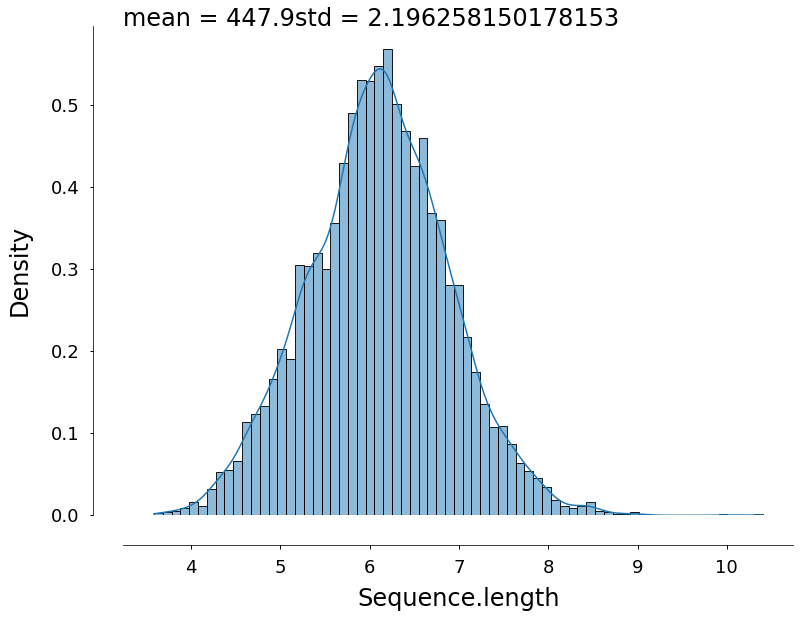

In [136]:
ax = sns.histplot(np.log(pdata.iloc[:,5]),stat='density',kde=True)
make_nice_axis(ax)
textstr = 'mean = ' + str(round(np.exp(np.mean(np.log(pdata.iloc[:,5]))),2)) + 'std = ' + str(np.exp(np.std(np.log(pdata.iloc[:,5]))));
ax.text(x=0,y=1,s=textstr,transform=ax.transAxes)
print(np.mean(np.log(pdata.iloc[:,5])),np.std(np.log(pdata.iloc[:,5])))
print(np.mean(pdata.iloc[:,5]))

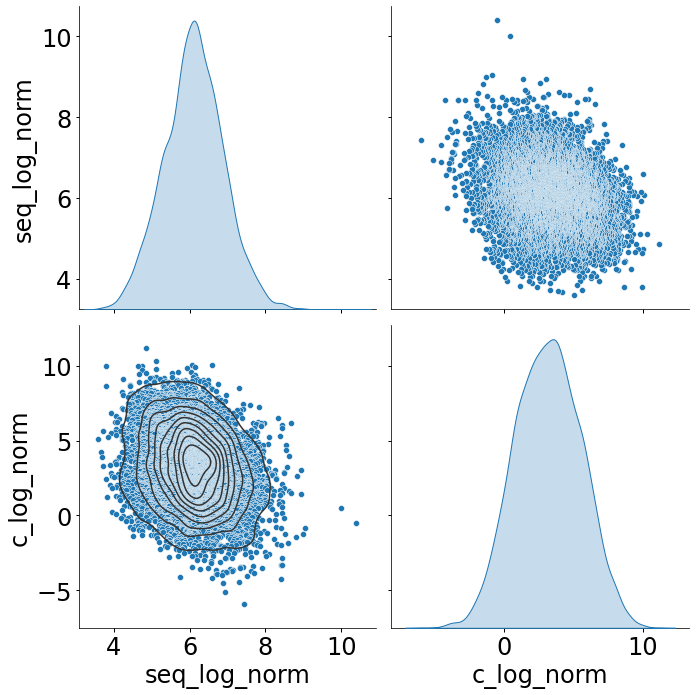

In [155]:
g = sns.pairplot(pdata,x_vars=["seq_log_norm", "c_log_norm"],
    y_vars=["seq_log_norm", "c_log_norm"],diag_kind="kde",height=5.0)
g.map_lower(sns.kdeplot, levels=10, color=".2")
file_save =True;
if file_save is True:
    output = '../Output/Proteome_data/distributions.pdf'
    os.makedirs(os.path.dirname(output),exist_ok=True)
    g.savefig(fname=output,dpi=300,format='pdf')
# make_nice_axis(ax)
# textstr = 'mean = ' + str(round(np.exp(np.mean(np.log(pdata.iloc[:,5]))),2)) + 'std = ' + str(np.exp(np.std(np.log(pdata.iloc[:,5]))));
# ax.text(x=0,y=1,s=textstr,transform=ax.transAxes)
# print(np.mean(np.log(pdata.iloc[:,5])),np.std(np.log(pdata.iloc[:,5])))
# print(np.mean(pdata.iloc[:,5]))


### Now repeating for phi,r

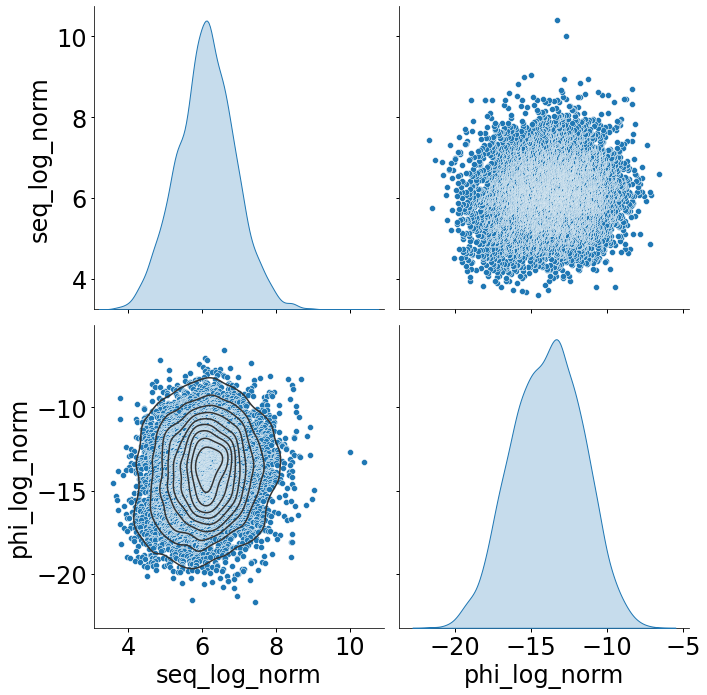

In [162]:
g = sns.pairplot(pdata,x_vars=["seq_log_norm", "phi_log_norm"],
    y_vars=["seq_log_norm", "phi_log_norm"],diag_kind="kde",height=5.0)
g.map_lower(sns.kdeplot, levels=10, color=".2")
file_save =True;
if file_save is True:
    output = '../Output/Proteome_data/distributions_with_phi.pdf'
    os.makedirs(os.path.dirname(output),exist_ok=True)
    g.savefig(fname=output,dpi=300,format='pdf')

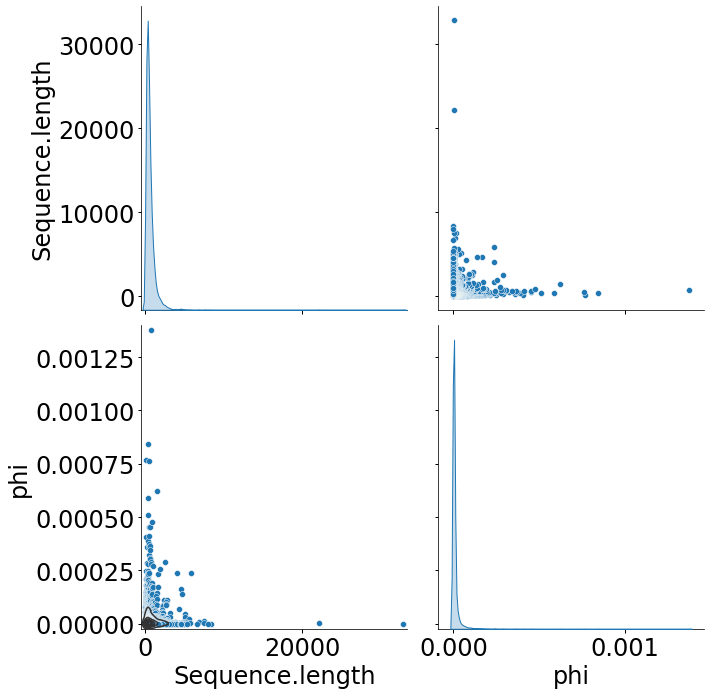

In [163]:
g = sns.pairplot(pdata,x_vars=["Sequence.length", "phi"],
    y_vars=["Sequence.length", "phi"],diag_kind="kde",height=5.0)
g.map_lower(sns.kdeplot, levels=10, color=".2")
file_save =True;
if file_save is True:
    output = '../Output/Proteome_data/distributions_with_phi_no_log.pdf'
    os.makedirs(os.path.dirname(output),exist_ok=True)
    g.savefig(fname=output,dpi=300,format='pdf')

In [ ]:
sns.histplot(np.log(pdata.iloc[:,5]),stat='density',kde=True)
print(np.mean(np.log(pdata.iloc[:,5])),np.std(np.log(pdata.iloc[:,5])))
print(np.mean(pdata.iloc[:,5]))

In [ ]:
fig,ax = plt.subplots(1,1)
make_nice_axis(ax)
ax.scatter(np.log(pdata.iloc[:,5]),np.log(pdata.iloc[:,-1]))
plt.show()

In [ ]:
phi = (pdata.iloc[:,-1]*pdata.iloc[:,5]*1e-9*140*1e-27*6.023*1e23)

In [ ]:
jacob_diag = 1 + 1/(phi*pdata.iloc[:,5])

In [ ]:
ax = sns.histplot(np.log(jacob_diag),stat='density',kde=True)
make_nice_axis(ax)

In [ ]:
np.mean(pdata.iloc[:,5])